BTC Time Series Project

Austin Diamond

Nathan Lam

Dataset: https://finance.yahoo.com/quote/BTC-USD/history/

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error


#Error Handling
pd.options.mode.chained_assignment = None

# Preprocessing

In [ ]:
# import the bitcoin dataset
from google.colab import files
files.upload();

Saving BTC-USD.csv to BTC-USD.csv


In [ ]:
# Load dataset into dataframe
bitcoin_df = pd.DataFrame(pd.read_csv("BTC-USD.csv"))

# Check column names
bitcoin_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
# Convert the Date column to datetime format
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])

# Set the Date column as the index
bitcoin_df.set_index('Date', inplace=True)
bitcoin_df.index = pd.to_datetime(bitcoin_df.index)

In [ ]:
# Show the first 5 rows of the dataframe
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-20,58115.082031,59859.878906,57469.726563,59697.195313,59697.195313,3.062426e+10
2021-11-21,59730.507813,60004.425781,58618.929688,58730.476563,58730.476563,2.612345e+10
2021-11-22,58706.847656,59266.359375,55679.839844,56289.289063,56289.289063,3.503612e+10
2021-11-23,56304.554688,57875.515625,55632.761719,57569.074219,57569.074219,3.748580e+10
2021-11-24,57565.851563,57803.066406,55964.222656,56280.425781,56280.425781,3.663557e+10


In [ ]:
# Show the data types for the columns
bitcoin_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
# Fill NaN values with mean
bitcoin_df = bitcoin_df.fillna(bitcoin_df.mean())

## Closing Prices Forecast


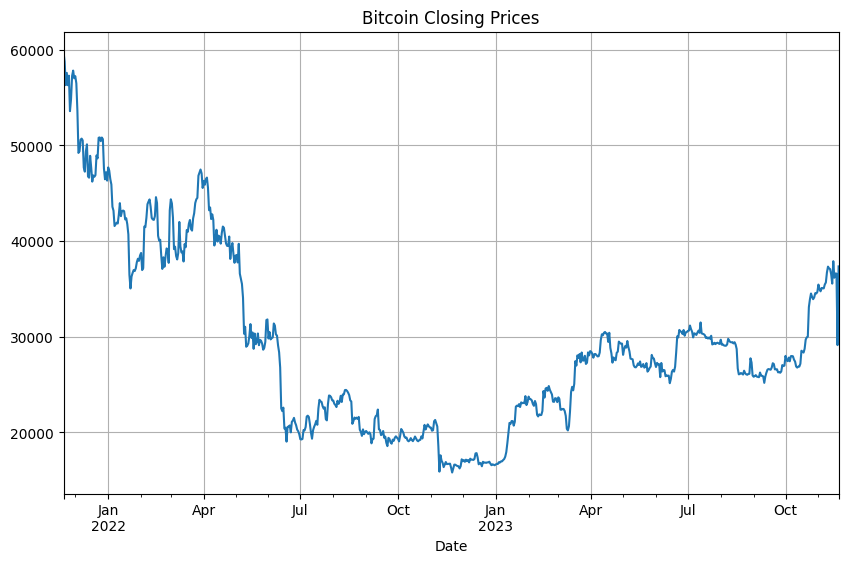

In [ ]:
# Step 1: Plot the closing prices
bitcoin_df['Close'].plot(figsize=(10, 6), title='Bitcoin Closing Prices')
plt.grid(True)
plt.show()

In [ ]:
# Step 2: Stationarity Test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test(bitcoin_df['Close'])

ADF Statistic: -3.0399981602797417
p-value: 0.03132417615300824
Critical Values: {'1%': -3.439464954327953, '5%': -2.8655625802683473, '10%': -2.5689120852623457}


* ADF Statistic determines if the time series is stationary or non-stationary. The more negative this is, the higher chance there is that the data is non-stationary.

* p-Value can determine the signifigance of the ADF Statistic. A value of 0.03 means the time series is likely stationary.

* Critical Values are threshold values that help you interpret the ADF Statistic.

**Based on the ADF test, the time series is stationary.**

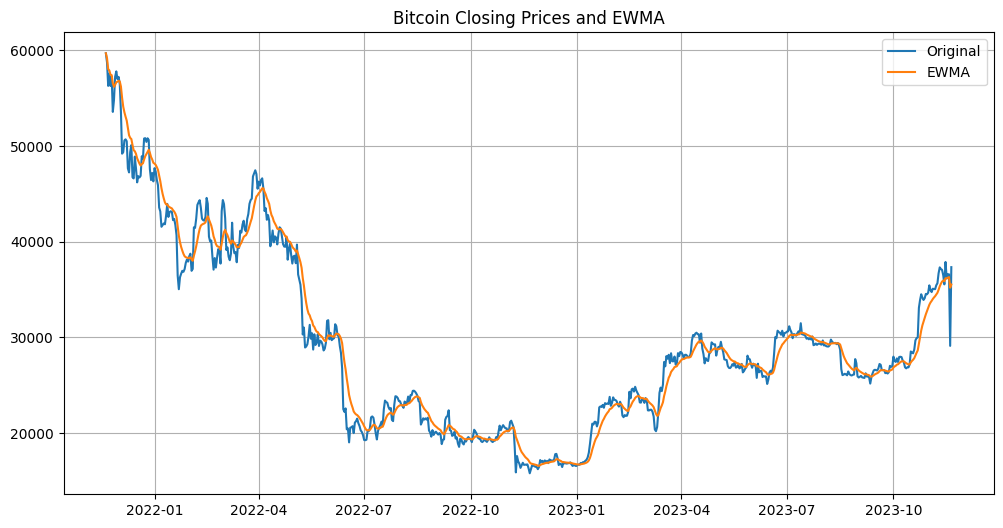

In [ ]:
# Step 3: Exponential Weighted Moving Average
bitcoin_df['Close_EWMA'] = bitcoin_df['Close'].ewm(span=12).mean()

# Plot the original and EWMA series
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Close'], label='Original')
plt.plot(bitcoin_df['Close_EWMA'], label='EWMA')
plt.legend()
plt.title('Bitcoin Closing Prices and EWMA')
plt.grid(True)
plt.show()


In [ ]:
# Step 4: ETS Model
model = ExponentialSmoothing(np.asarray(bitcoin_df['Close_EWMA']), seasonal='add', seasonal_periods=7)
result = model.fit(method='Powell')


In [ ]:
# Step 5: Train-Test Split
train_size = int(len(bitcoin_df) * 0.8)
train, test = bitcoin_df.iloc[:train_size], bitcoin_df.iloc[train_size:]

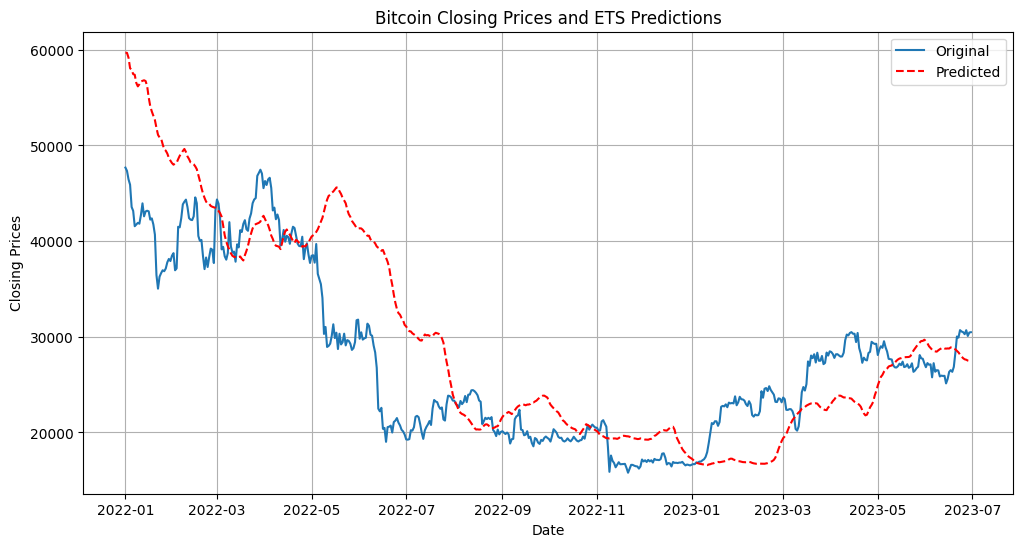

In [ ]:
# Step 6: Predictions
start_date = '2022-01-01'
end_date = '2023-06-30'

# Filter the data and predictions for the specified quarter
quarter_data = bitcoin_df.loc[start_date:end_date]

# Use the index for predictions
quarter_predictions_index = pd.date_range(start=start_date, end=end_date, freq='D')
quarter_predictions = pd.Series(result.predict(start=0, end=len(quarter_predictions_index)-1), index=quarter_predictions_index)

# Plot original and predicted values for the specified quarter
plt.figure(figsize=(12, 6))
plt.plot(quarter_data['Close'], label='Original')
plt.plot(quarter_predictions.index, quarter_predictions, label='Predicted', linestyle='--', color='red')
plt.legend()
plt.title('Bitcoin Closing Prices and ETS Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.grid(True)
plt.show()



In [ ]:
# Step 7: Evaluate on Test Set
test_predictions = result.predict(start=len(train), end=len(train) + len(test) - 1)


In [ ]:
# Step 8: Evaluate accuracy
mse = mean_squared_error(quarter_data['Close'], quarter_predictions)
rmse = sqrt(mse)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Min Closing Price Value =', bitcoin_df['Close'].min())
print('Max Closing Price Value =', bitcoin_df['Close'].max())

Mean Squared Error (MSE): 43250750.42097607
Root Mean Squared Error (RMSE): 6576.530272185788
Min Closing Price Value = 15787.28418
Max Closing Price Value = 59697.195313


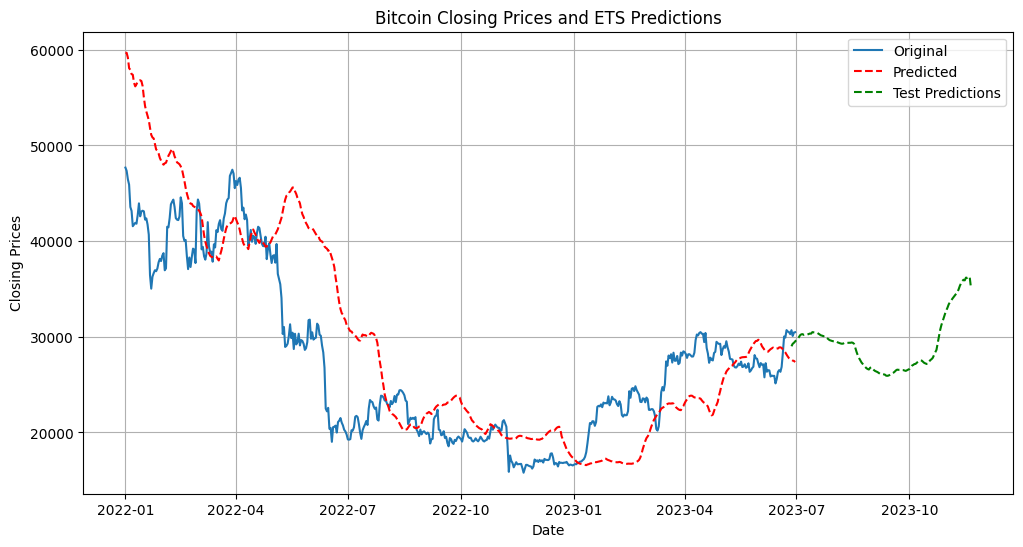

In [ ]:
# Plot original and predicted values for the specified quarter
plt.figure(figsize=(12, 6))
plt.plot(quarter_data['Close'], label='Original')
plt.plot(quarter_predictions.index, quarter_predictions, label='Predicted', linestyle='--', color='red')
plt.plot(test.index, test_predictions, label='Test Predictions', linestyle='--', color='green')  # Include test predictions in the plot
plt.legend()
plt.title('Bitcoin Closing Prices and ETS Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.grid(True)
plt.show()

## Volume Forecast

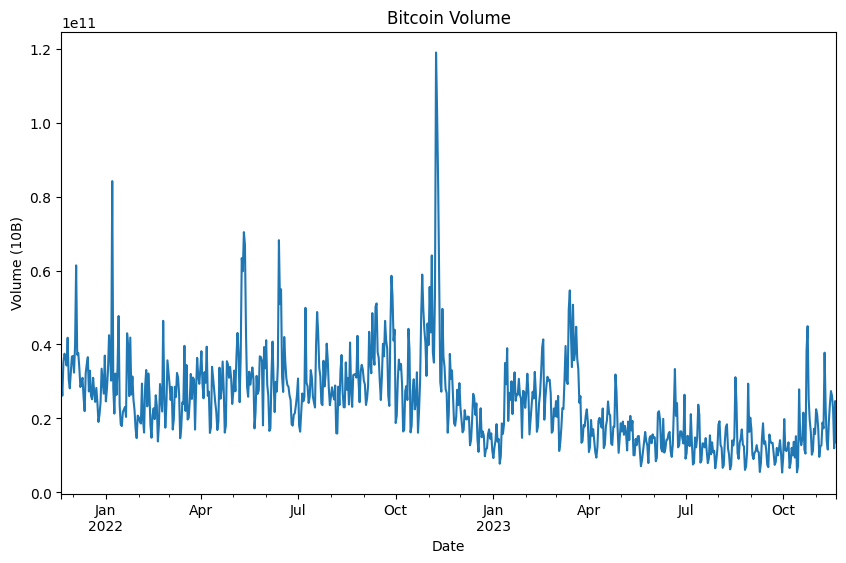

In [ ]:
# Step 1: Plot the closing prices
bitcoin_df['Volume'].plot(figsize=(10, 6), title='Bitcoin Volume')
plt.xlabel('Date')
plt.ylabel('Volume (10B)')
plt.show()

In [ ]:
# Step 2: Stationarity Test
adf_test(bitcoin_df['Volume'])

ADF Statistic: -3.504923517503132
p-value: 0.007861544379950946
Critical Values: {'1%': -3.439516060164992, '5%': -2.8655850998755263, '10%': -2.5689240826597173}


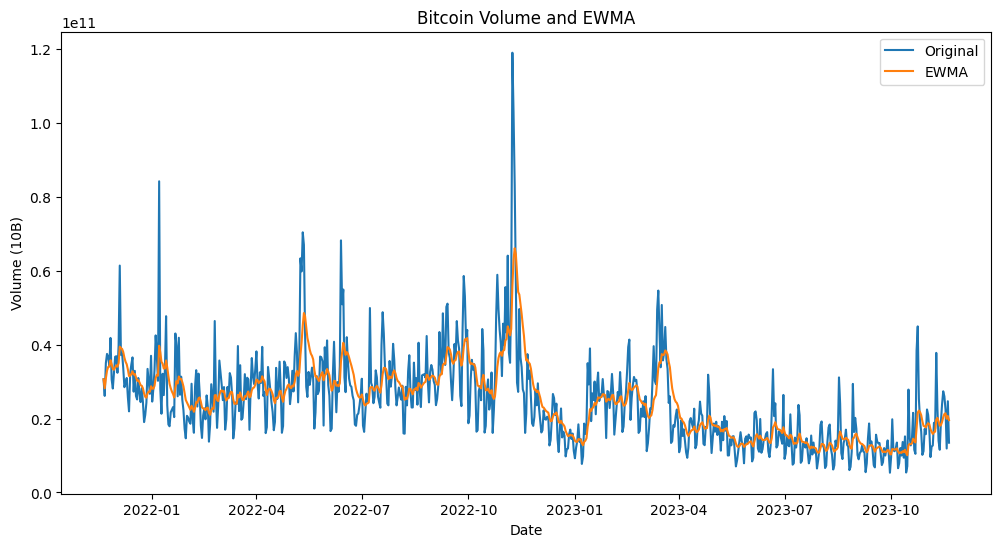

In [ ]:
# Step 3: Exponential Weighted Moving Average
bitcoin_df['Volume_EWMA'] = bitcoin_df['Volume'].ewm(span=12).mean()

# Plot the original and EWMA series
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Volume'], label='Original')
plt.plot(bitcoin_df['Volume_EWMA'], label='EWMA')
plt.legend()
plt.title('Bitcoin Volume and EWMA')
plt.xlabel('Date')
plt.ylabel('Volume (10B)')
plt.show()

In [ ]:
# Step 4: ETS Model
model = ExponentialSmoothing(np.asarray(bitcoin_df['Volume_EWMA']), seasonal='add', seasonal_periods=7)
result = model.fit(method='Powell')

In [ ]:
# Step 5: Train-Test Split
v_train_size = int(len(bitcoin_df) * 0.8)
v_train, v_test = bitcoin_df.iloc[:train_size], bitcoin_df.iloc[train_size:]

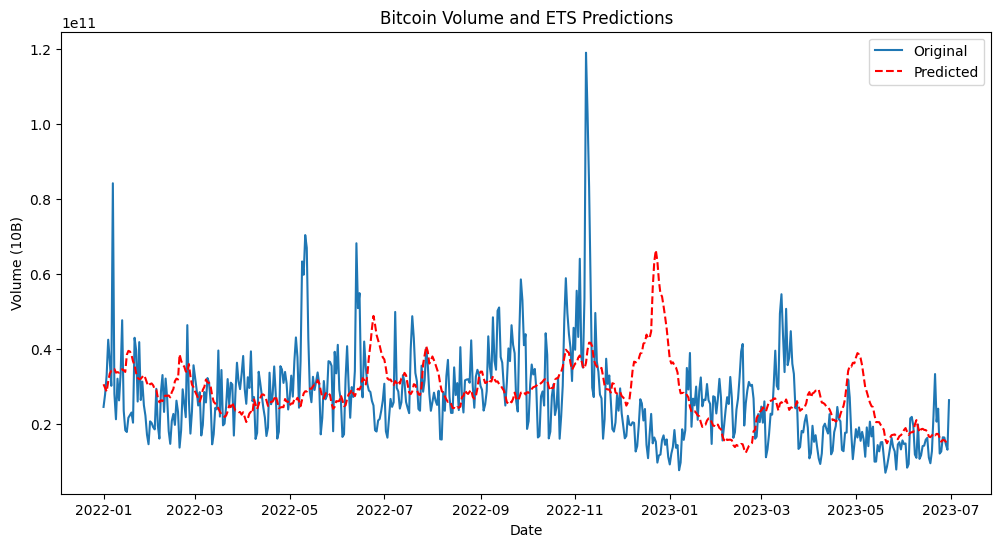

In [ ]:
# Step 6: Predictions
start_date = '2022-01-01'
end_date = '2023-06-30'

# Filter the data and predictions for the specified quarter
v_quarter_data = bitcoin_df.loc[start_date:end_date]

# Use the index for predictions
v_quarter_predictions_index = pd.date_range(start=start_date, end=end_date, freq='D')
v_quarter_predictions = pd.Series(result.predict(start=0, end=len(v_quarter_predictions_index)-1), index=v_quarter_predictions_index)

# Plot original and predicted values for the specified quarter
plt.figure(figsize=(12, 6))
plt.plot(v_quarter_data['Volume'], label='Original')
plt.plot(v_quarter_predictions.index, v_quarter_predictions, label='Predicted', linestyle='--', color='red')
plt.legend()
plt.title('Bitcoin Volume and ETS Predictions')
plt.xlabel('Date')
plt.ylabel('Volume (10B)')
plt.show()

In [ ]:
# Step 7: Evaluate on Test Set
v_test_predictions = result.predict(start=len(v_train), end=len(v_train) + len(v_test) - 1)

In [ ]:
# Step 8: Evaluate accuracy
v_mse = mean_squared_error(quarter_data['Volume'], v_quarter_predictions)
v_rmse = sqrt(v_mse)

print('Mean Squared Error (MSE):', v_mse)
print('Root Mean Squared Error (RMSE):', v_rmse)
print('Min Volume Value =', bitcoin_df['Volume'].min())
print('Max Volume Value =', bitcoin_df['Volume'].max())

Mean Squared Error (MSE): 1.8744714623821762e+20
Root Mean Squared Error (RMSE): 13691133855.098255
Min Volume Value = 5331172801.0
Max Volume Value = 118992465607.0


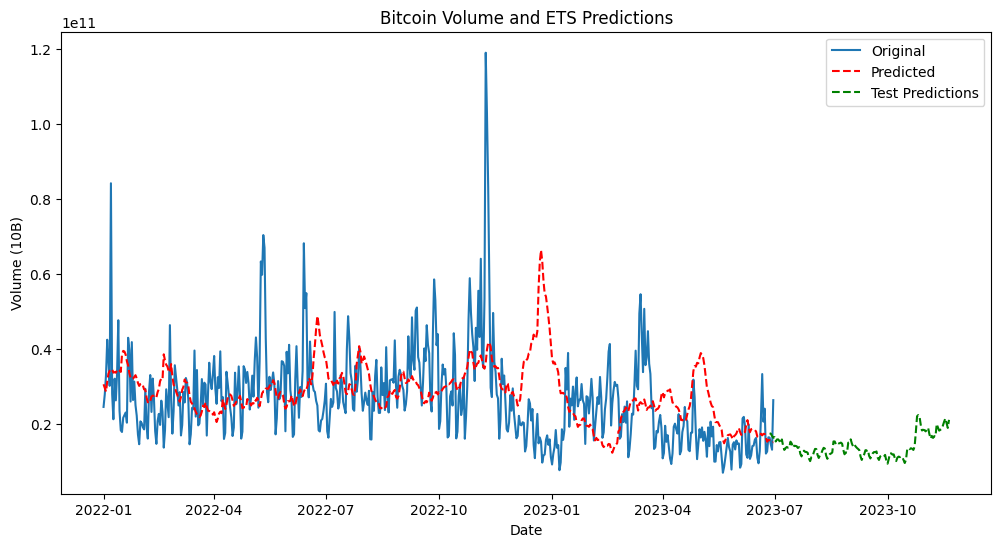

In [ ]:
# Plot original and predicted values for the specified quarter
plt.figure(figsize=(12, 6))
plt.plot(v_quarter_data['Volume'], label='Original')
plt.plot(v_quarter_predictions.index, v_quarter_predictions, label='Predicted', linestyle='--', color='red')
plt.plot(v_test.index, v_test_predictions, label='Test Predictions', linestyle='--', color='green')  # Include test predictions in the plot
plt.legend()
plt.title('Bitcoin Volume and ETS Predictions')
plt.xlabel('Date')
plt.ylabel('Volume (10B)')
plt.show()